In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import os, joblib, warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
df = pd.read_csv('Daily.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
df.drop(columns=['Unnamed: 0'], inplace=True)
df['YearMonth'] = df['Date'].dt.to_period('M').dt.to_timestamp()

In [3]:

# Encode groundwater level legend
level_map = {
    'Shallow Water Level (0 to 5)': 0,
    'Moderate Water Level (5 to 10)': 1,
    'Moderately Deep Water Level (10 to 20)': 2,
    'Deep Water Level (20 to 40)': 3,
    'Very Deep Water Level (40+)': 4
}
df['GW_Level_Code'] = df['GW_Level_Legend'].map(level_map)


In [4]:
# Monthly aggregation
monthly_df = df.groupby(['District', 'Mandal', 'YearMonth']).agg({
    'Rain (mm)': 'mean',
    'Avg_Temp': 'mean',
    'Avg_Humidity': 'mean',
    'Avg_Wind_Speed': 'mean',
    'GW_Level_Code': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
}).reset_index()

In [5]:
monthly_df.head()

,District,Mandal,YearMonth,Rain (mm),Avg_Temp,Avg_Humidity,Avg_Wind_Speed,GW_Level_Code
0,Adilabad,Adilabad Rural,2023-02-01,0.000000,24.075000,45.985714,5.675000,3.0
1,Adilabad,Adilabad Rural,2023-03-01,0.025806,28.004839,49.932258,6.380645,3.0
2,Adilabad,Adilabad Rural,2023-04-01,0.380000,31.328333,48.435000,7.098333,1.0
3,Adilabad,Adilabad Rural,2023-05-01,1.900000,32.530645,52.353226,6.474194,1.0
4,Adilabad,Adilabad Rural,2023-06-01,3.270000,33.210000,55.088333,6.331667,1.0


In [6]:
print("Unique Mandals:", monthly_df['Mandal'].nunique())
print("Date Range:", monthly_df['YearMonth'].min(), "to", monthly_df['YearMonth'].max())


Unique Mandals: 598
Date Range: 2023-02-01 00:00:00 to 2025-01-01 00:00:00


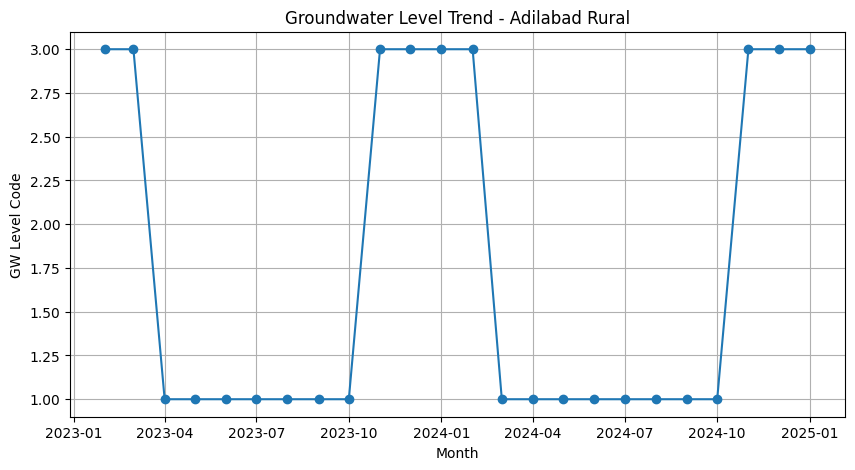

In [7]:
import matplotlib.pyplot as plt

# Example: Trend of groundwater level for one mandal
mandal_name = 'Adilabad Rural'
mandal_data = monthly_df[monthly_df['Mandal'] == mandal_name]

plt.figure(figsize=(10, 5))
plt.plot(mandal_data['YearMonth'], mandal_data['GW_Level_Code'], marker='o')
plt.title(f"Groundwater Level Trend - {mandal_name}")
plt.xlabel("Month")
plt.ylabel("GW Level Code")
plt.grid(True)
plt.show()


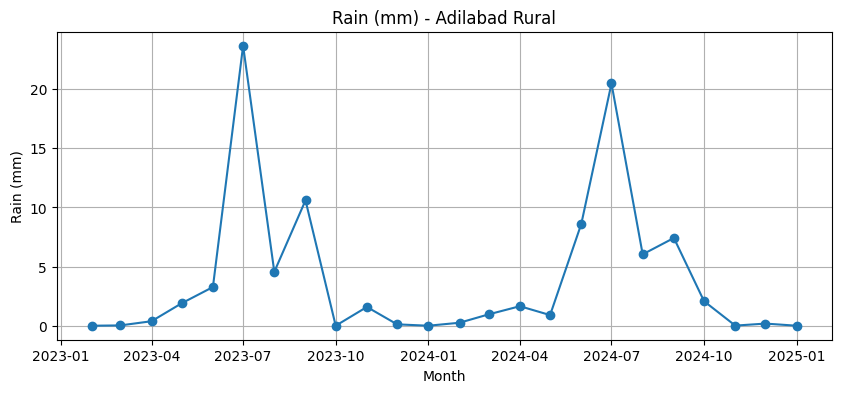

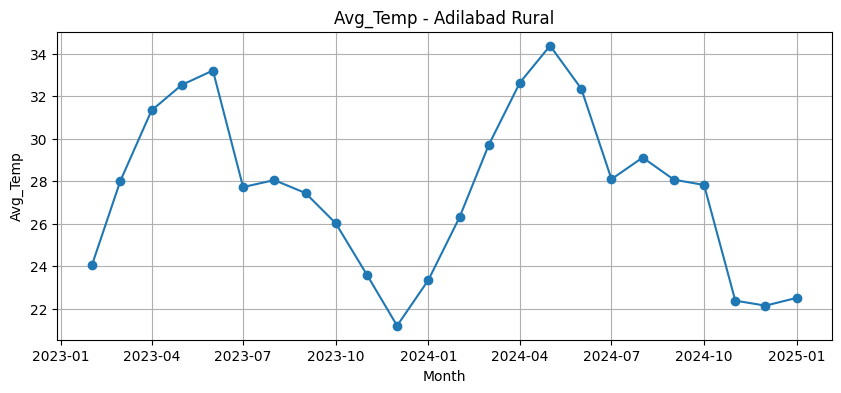

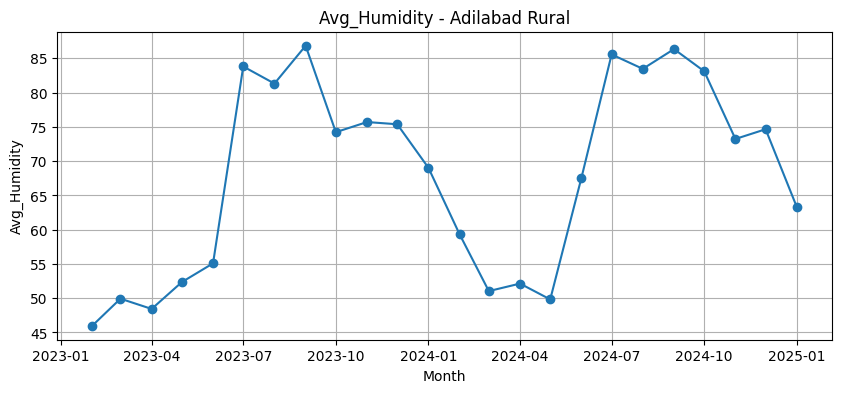

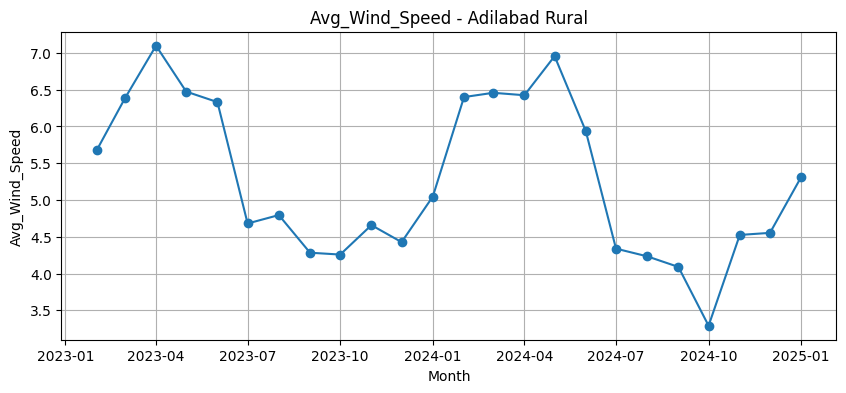

In [8]:
features = ['Rain (mm)', 'Avg_Temp', 'Avg_Humidity', 'Avg_Wind_Speed']
for feature in features:
    plt.figure(figsize=(10, 4))
    plt.plot(mandal_data['YearMonth'], mandal_data[feature], marker='o')
    plt.title(f"{feature} - {mandal_name}")
    plt.xlabel("Month")
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()


<Axes: >

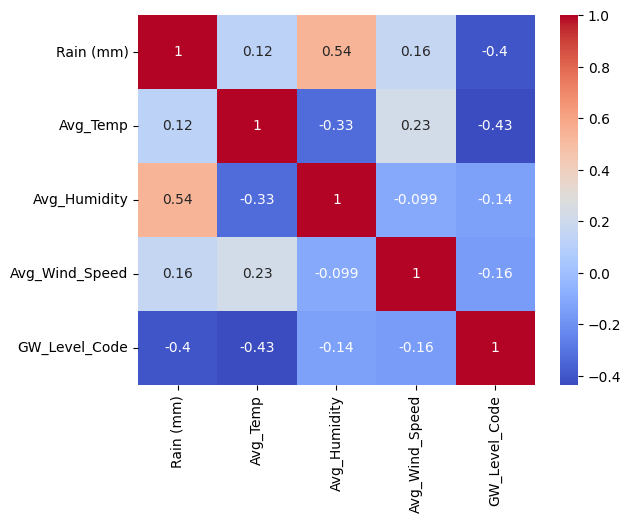

In [9]:
corr = monthly_df[['Rain (mm)', 'Avg_Temp', 'Avg_Humidity', 'Avg_Wind_Speed', 'GW_Level_Code']].corr()
import seaborn as sns
sns.heatmap(corr, annot=True, cmap='coolwarm')


In [10]:
print(monthly_df.isnull().sum())


District             0
Mandal               0
YearMonth            0
Rain (mm)            0
Avg_Temp             0
Avg_Humidity         0
Avg_Wind_Speed       0
GW_Level_Code     1246
dtype: int64


In [11]:
monthly_df.shape

(14616, 8)

In [12]:

monthly_df = monthly_df.dropna(subset=['GW_Level_Code'])

In [13]:
monthly_df.shape

(13370, 8)

In [14]:
monthly_df['Month'] = monthly_df['YearMonth'].dt.month

# Define season based on months
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

monthly_df['Season'] = monthly_df['Month'].apply(get_season)


In [15]:
monthly_df.head()

,District,Mandal,YearMonth,Rain (mm),Avg_Temp,Avg_Humidity,Avg_Wind_Speed,GW_Level_Code,Month,Season
0,Adilabad,Adilabad Rural,2023-02-01,0.000000,24.075000,45.985714,5.675000,3.0,2,Winter
1,Adilabad,Adilabad Rural,2023-03-01,0.025806,28.004839,49.932258,6.380645,3.0,3,Summer
2,Adilabad,Adilabad Rural,2023-04-01,0.380000,31.328333,48.435000,7.098333,1.0,4,Summer
3,Adilabad,Adilabad Rural,2023-05-01,1.900000,32.530645,52.353226,6.474194,1.0,5,Summer
4,Adilabad,Adilabad Rural,2023-06-01,3.270000,33.210000,55.088333,6.331667,1.0,6,Monsoon


In [16]:
# Sort first
monthly_df = monthly_df.sort_values(by=['Mandal', 'YearMonth'])




In [17]:
# Create lag features
monthly_df['GW_Level_Lag1'] = monthly_df.groupby('Mandal')['GW_Level_Code'].shift(1)
monthly_df['Rain_Lag1'] = monthly_df.groupby('Mandal')['Rain (mm)'].shift(1)

In [18]:
monthly_df.head()

,District,Mandal,YearMonth,Rain (mm),Avg_Temp,Avg_Humidity,Avg_Wind_Speed,GW_Level_Code,Month,Season,GW_Level_Lag1,Rain_Lag1
8417,Narayanpet,14,2023-07-01,7.893548,26.098387,85.670968,5.056452,1.0,7,Monsoon,NaN,NaN
8419,Narayanpet,14,2023-09-01,5.990000,26.595000,84.916667,3.105000,1.0,9,Monsoon,1.0,7.893548
8420,Narayanpet,14,2023-10-01,0.283871,26.438710,70.535484,2.082258,3.0,10,Post-Monsoon,1.0,5.990000
8421,Narayanpet,14,2023-11-01,0.066667,25.635000,75.690000,2.060000,3.0,11,Post-Monsoon,3.0,0.283871
8422,Narayanpet,14,2023-12-01,0.000000,23.066129,70.296774,1.856452,3.0,12,Winter,3.0,0.066667


In [19]:
print(monthly_df.isnull().sum())

District            0
Mandal              0
YearMonth           0
Rain (mm)           0
Avg_Temp            0
Avg_Humidity        0
Avg_Wind_Speed      0
GW_Level_Code       0
Month               0
Season              0
GW_Level_Lag1     598
Rain_Lag1         598
dtype: int64


In [20]:
monthly_df = monthly_df.dropna()


In [21]:
monthly_df.shape

(12772, 12)

In [22]:
# 3-month moving average
monthly_df['Rain_3MA'] = monthly_df.groupby('Mandal')['Rain (mm)'].transform(lambda x: x.rolling(3).mean())
monthly_df['GW_Level_3MA'] = monthly_df.groupby('Mandal')['GW_Level_Code'].transform(lambda x: x.rolling(3).mean())


In [23]:
print(monthly_df.isnull().sum())

District             0
Mandal               0
YearMonth            0
Rain (mm)            0
Avg_Temp             0
Avg_Humidity         0
Avg_Wind_Speed       0
GW_Level_Code        0
Month                0
Season               0
GW_Level_Lag1        0
Rain_Lag1            0
Rain_3MA          1196
GW_Level_3MA      1196
dtype: int64


In [24]:
monthly_df = monthly_df.dropna()

In [25]:
print(monthly_df.isnull().sum())

District          0
Mandal            0
YearMonth         0
Rain (mm)         0
Avg_Temp          0
Avg_Humidity      0
Avg_Wind_Speed    0
GW_Level_Code     0
Month             0
Season            0
GW_Level_Lag1     0
Rain_Lag1         0
Rain_3MA          0
GW_Level_3MA      0
dtype: int64


In [26]:
monthly_df.head()

,District,Mandal,YearMonth,Rain (mm),Avg_Temp,Avg_Humidity,Avg_Wind_Speed,GW_Level_Code,Month,Season,GW_Level_Lag1,Rain_Lag1,Rain_3MA,GW_Level_3MA
8421,Narayanpet,14,2023-11-01,0.066667,25.635000,75.690000,2.060000,3.0,11,Post-Monsoon,3.0,0.283871,2.113513,2.333333
8422,Narayanpet,14,2023-12-01,0.000000,23.066129,70.296774,1.856452,3.0,12,Winter,3.0,0.066667,0.116846,3.000000
8423,Narayanpet,14,2024-01-01,0.000000,23.803226,67.996774,1.845161,3.0,1,Winter,3.0,0.000000,0.022222,3.000000
8424,Narayanpet,14,2024-02-01,0.000000,26.048276,57.486207,2.451724,3.0,2,Winter,3.0,0.000000,0.000000,3.000000
8427,Narayanpet,14,2024-05-01,2.516129,32.391935,52.904839,3.759677,1.0,5,Summer,3.0,0.000000,0.838710,2.333333


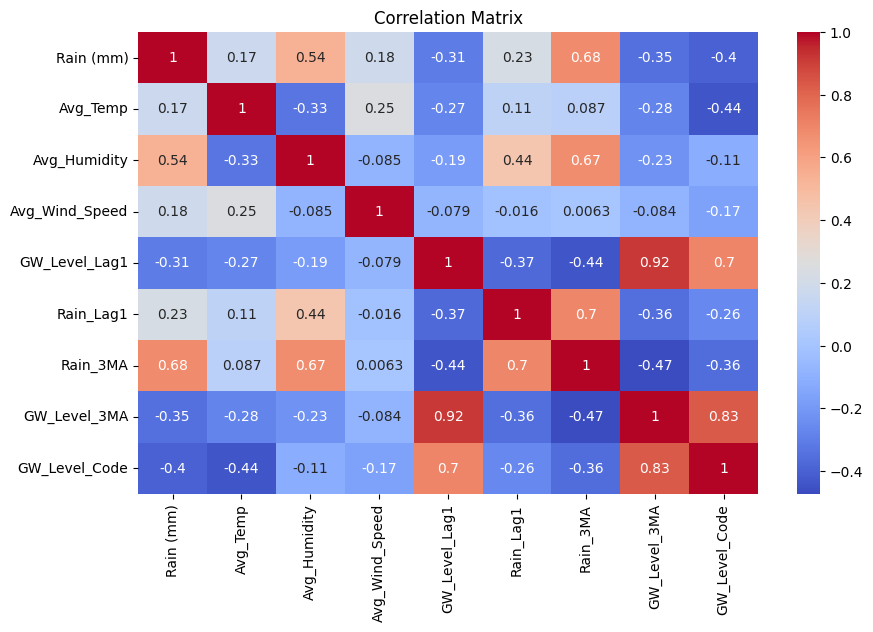

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_cols = [
    'Rain (mm)', 'Avg_Temp', 'Avg_Humidity', 'Avg_Wind_Speed',
    'GW_Level_Lag1', 'Rain_Lag1', 'Rain_3MA', 'GW_Level_3MA', 'GW_Level_Code'
]

corr = monthly_df[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


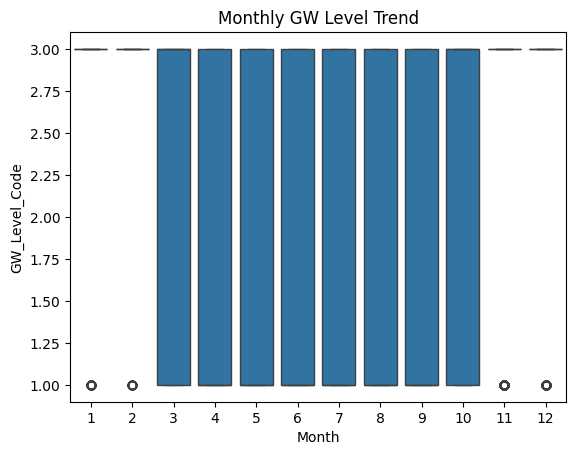

In [28]:
sns.boxplot(x='Month', y='GW_Level_Code', data=monthly_df)
plt.title("Monthly GW Level Trend")
plt.show()


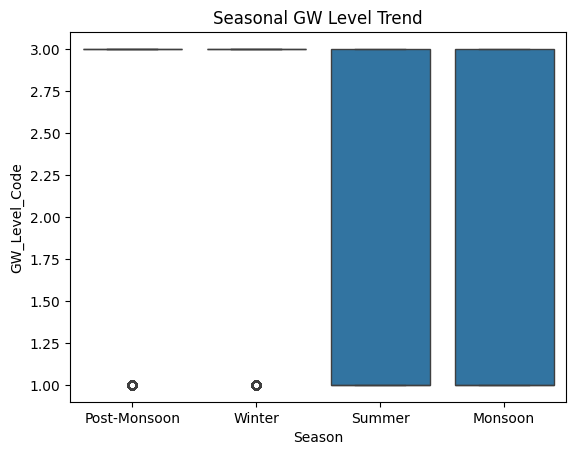

In [29]:
sns.boxplot(x='Season', y='GW_Level_Code', data=monthly_df)
plt.title("Seasonal GW Level Trend")
plt.show()


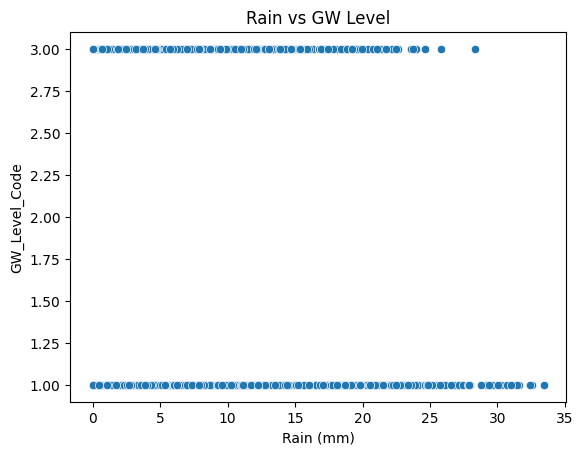

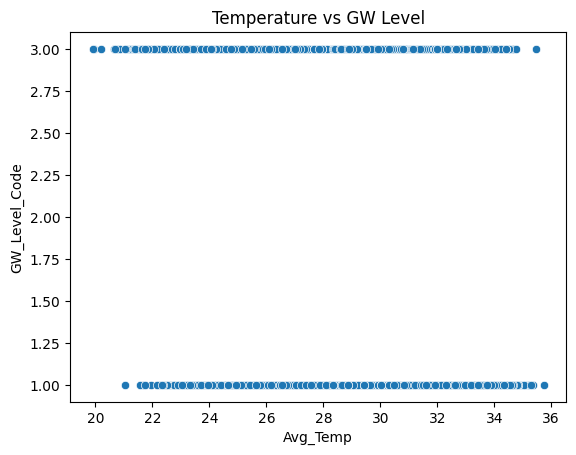

In [30]:
sns.scatterplot(x='Rain (mm)', y='GW_Level_Code', data=monthly_df)
plt.title("Rain vs GW Level")
plt.show()

sns.scatterplot(x='Avg_Temp', y='GW_Level_Code', data=monthly_df)
plt.title("Temperature vs GW Level")
plt.show()


In [31]:
print(monthly_df.columns.tolist())

['District', 'Mandal', 'YearMonth', 'Rain (mm)', 'Avg_Temp', 'Avg_Humidity', 'Avg_Wind_Speed', 'GW_Level_Code', 'Month', 'Season', 'GW_Level_Lag1', 'Rain_Lag1', 'Rain_3MA', 'GW_Level_3MA']


In [32]:
features = [
    'Rain (mm)',
    'Avg_Temp',
    'Avg_Humidity',
    'GW_Level_Lag1',
    'Rain_3MA',
    'Month'
]

target = 'GW_Level_Code'


In [33]:
monthly_df.dtypes

District                  object
Mandal                    object
YearMonth         datetime64[ns]
Rain (mm)                float64
Avg_Temp                 float64
Avg_Humidity             float64
Avg_Wind_Speed           float64
GW_Level_Code            float64
Month                      int32
Season                    object
GW_Level_Lag1            float64
Rain_Lag1                float64
Rain_3MA                 float64
GW_Level_3MA             float64
dtype: object

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_df[features])


In [35]:
# Ensure all Mandal values are strings
monthly_df['Mandal'] = monthly_df['Mandal'].astype(str)


In [36]:
from sklearn.preprocessing import LabelEncoder

# Fix column
monthly_df['Mandal'] = monthly_df['Mandal'].astype(str)

# Encode
le = LabelEncoder()
monthly_df['Mandal_Code'] = le.fit_transform(monthly_df['Mandal'])

# Update features list
features.append('Mandal_Code')

# Optional: Show mapping
mandal_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mandal Encoding Mapping:")
print(mandal_mapping)


Mandal Encoding Mapping:
{'14': 0, '15': 1, '17': 2, '18': 3, '19': 4, '20': 5, '23': 6, '24': 7, '25': 8, '26': 9, '28': 10, '30': 11, '31': 12, '32': 13, '33': 14, 'Abdullapurmet': 15, 'Achampet': 16, 'Adavi Devula Palli': 17, 'Addagudur': 18, 'Addakal': 19, 'Adilabad Rural': 20, 'Adilabad Urban': 21, 'Aiza': 22, 'Alair': 23, 'Alampur': 24, 'Alladurg': 25, 'Allapalli': 26, 'Alwal': 27, 'Amangal': 28, 'Amarchinta': 29, 'Amberpet': 30, 'Ameenapur': 31, 'Ameerpet': 32, 'Amrabad': 33, 'Ananthagiri': 34, 'Andhole': 35, 'Annapureddipalle': 36, 'Antargoan': 37, 'Anthakkapeta': 38, 'Anumula_Haliya': 39, 'Armur': 40, 'Asifabad': 41, 'Asifnagar': 42, 'Aswapuram': 43, 'Aswaraopeta': 44, 'Atmakur': 45, 'Atmakur_M': 46, 'Atmakur_S': 47, 'Bachannapeta': 48, 'Bachpalle': 49, 'Bahadurpura': 50, 'Balanagar': 51, 'Balapur': 52, 'Balkonda': 53, 'Balmoor': 54, 'Bandlaguda': 55, 'Banswada': 56, 'Bantwaram': 57, 'Basar': 58, 'Basheerabad': 59, 'Bayyaram': 60, 'Bazarhathnoor': 61, 'Beerpur': 62, 'Bejjanki'

In [37]:
monthly_df.to_csv("monthly_df.csv", index=False)


In [37]:
import numpy as np

def create_sequences(data, target_array, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])        # All features
        y.append(target_array[i+sequence_length])  # Separate target
    return np.array(X), np.array(y)

# Now call like this:
scaled_features = scaler.fit_transform(monthly_df[features])
target_array = monthly_df[target].values

# Set sequence length (e.g., using last 3 months to predict next)
sequence_length = 3

X, y = create_sequences(scaled_features, target_array, sequence_length)


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # No shuffle for time series!
)


In [39]:
from tensorflow.keras.utils import to_categorical

# Assuming GW_Level_Code is like 1.0, 2.0, 3.0
# Convert to int
y_class = y.astype(int)
y_cat = to_categorical(y_class)  # shape becomes (samples, num_classes)


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

num_classes = y_cat.shape[1]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')  # softmax for multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [41]:
X_train, X_test, y_train_cat, y_test_cat = train_test_split(
    X, y_cat, test_size=0.2, shuffle=False
)

model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=50,
    batch_size=32
)


Epoch 1/50


290/290 [==============================] - 6s 9ms/step - loss: 0.6329 - accuracy: 0.7067 - val_loss: 0.4727 - val_accuracy: 0.8104
Epoch 2/50
290/290 [==============================] - 1s 5ms/step - loss: 0.4696 - accuracy: 0.7921 - val_loss: 0.4154 - val_accuracy: 0.8337
Epoch 3/50
290/290 [==============================] - 1s 5ms/step - loss: 0.4279 - accuracy: 0.8082 - val_loss: 0.3942 - val_accuracy: 0.8311
Epoch 4/50
290/290 [==============================] - 1s 5ms/step - loss: 0.4129 - accuracy: 0.8219 - val_loss: 0.3998 - val_accuracy: 0.8073
Epoch 5/50
290/290 [==============================] - 1s 5ms/step - loss: 0.4073 - accuracy: 0.8239 - val_loss: 0.3849 - val_accuracy: 0.8268
Epoch 6/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3969 - accuracy: 0.8242 - val_loss: 0.3834 - val_accuracy: 0.8212
Epoch 7/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3899 - accuracy: 0.8298 - val_loss: 0.3667 - val_accuracy: 0.8328
Epoc

73/73 [==============================] - 3s 7ms/step


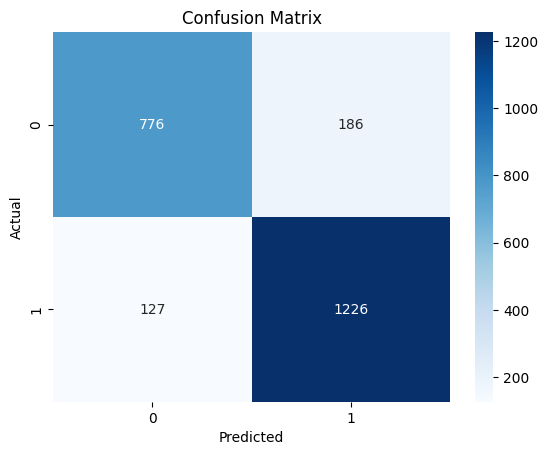

              precision    recall  f1-score   support

           1       0.86      0.81      0.83       962
           3       0.87      0.91      0.89      1353

    accuracy                           0.86      2315
   macro avg       0.86      0.86      0.86      2315
weighted avg       0.86      0.86      0.86      2315



In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))



In [43]:
import numpy as np

def forecast_future_levels(model, last_known_sequence, future_steps=6):
    future_preds = []

    current_seq = last_known_sequence.copy()

    for _ in range(future_steps):
        pred = model.predict(current_seq.reshape(1, current_seq.shape[0], current_seq.shape[1]))
        predicted_class = np.argmax(pred, axis=1)[0]
        future_preds.append(predicted_class)

        # Update the sequence with predicted values
        new_input = current_seq[-1].copy()
        new_input[3] = predicted_class  # Replace GW_Level_Lag1
        current_seq = np.vstack([current_seq[1:], new_input])

    return future_preds


In [44]:
timesteps = sequence_length  # usually 3
mandals = monthly_df['Mandal'].unique()

mandal_forecasts = {}

for mandal in mandals:
    mandal_df = monthly_df[monthly_df['Mandal'] == mandal].copy()
    
    if len(mandal_df) >= timesteps:
        sequence = mandal_df[features].values[-timesteps:]
        scaled_seq = scaler.transform(sequence)
        forecast = forecast_future_levels(model, scaled_seq, future_steps=6)
        mandal_forecasts[mandal] = forecast

# Example output
for mandal, forecast in mandal_forecasts.items():
    print(f"{mandal}: {forecast}")


1/1 [==============================] - 0s 26ms/step
14: [1, 3, 3, 3, 3, 3]
15: [3, 3, 3, 3, 3, 3]
17: [3, 3, 3, 3, 3, 3]
18: [1, 3, 3, 3, 3, 3]
19: [1, 3, 3, 3, 3, 3]
20: [3, 3, 3, 3, 3, 3]
23: [1, 3, 3, 3, 3, 3]
24: [1, 3, 3, 3, 3, 3]
25: [3, 3, 3, 3, 3, 3]
26: [1, 3, 3, 3, 3, 3]
28: [3, 3, 3, 3, 3, 3]
30: [1, 3, 3, 3, 3, 3]
31: [1, 3, 3, 3, 3, 3]
32: [3, 3, 3, 3, 3, 3]
33: [1, 3, 3, 3, 3, 3]
Abdullapurmet: [3, 3, 3, 3, 3, 3]
Achampet: [3, 3, 3, 3, 3, 3]
Adavi Devula Palli: [1, 3, 3, 3, 3, 3]
Addagudur: [1, 3, 3, 3, 3, 3]
Addakal: [1, 3, 3, 3, 3, 3]
Adilabad Rural: [1, 3, 3, 3, 3, 3]
Adilabad Urban: [1, 3, 3, 3, 3, 3]
Aiza: [3, 3, 3, 3, 3, 3]
Alair: [1, 3, 3, 3, 3, 3]
Alampur: [3, 3, 3, 3, 3, 3]
Alladurg: [1, 3, 3, 3, 3, 3]
Allapalli: [3, 3, 3, 3, 3, 3]
Alwal: [3, 3, 3, 3, 3, 3]
Amangal: [1, 3, 3, 3, 3, 3]
Amarchinta: [3, 3, 3, 3, 3, 3]
Amberpet: [1, 3, 3, 3, 3, 3]
Ameenapur: [1, 3, 3, 3, 3, 3]
Ameerpet: [1, 3, 3, 3, 3, 3]
Amrabad: [1, 3, 3, 3, 3, 3]
Ananthagiri: [3, 3, 3, 3, 3, 3]
An

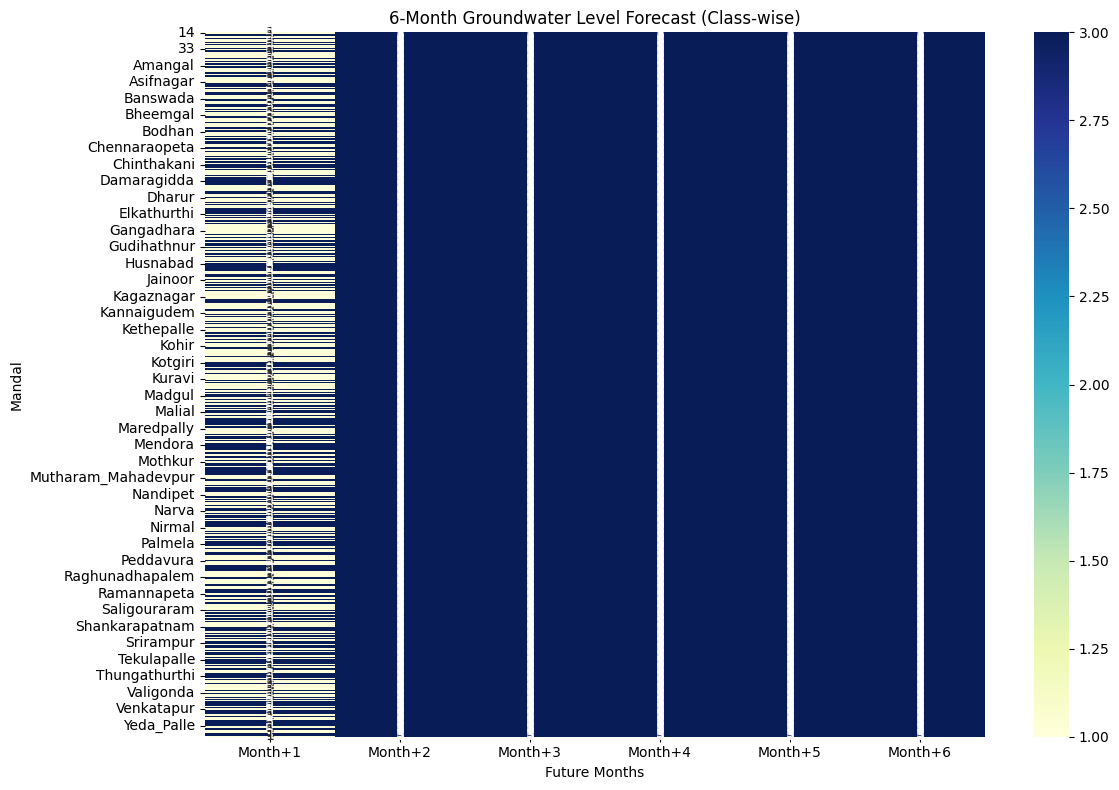

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

forecast_df = pd.DataFrame(mandal_forecasts).T
forecast_df.columns = [f"Month+{i+1}" for i in range(forecast_df.shape[1])]

plt.figure(figsize=(12, 8))
sns.heatmap(forecast_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title("6-Month Groundwater Level Forecast (Class-wise)")
plt.ylabel("Mandal")
plt.xlabel("Future Months")
plt.tight_layout()
plt.show()


In [46]:
import os
import joblib
from tensorflow.keras.models import load_model

# Directory to save models
save_dir = "model_artifacts"
os.makedirs(save_dir, exist_ok=True)

# 1. Save the trained LSTM model
model_path = os.path.join(save_dir, "gw_lstm_model.h5")
model.save(model_path)
print(f"Model saved to: {model_path}")

# 2. Save the MinMaxScaler
scaler_path = os.path.join(save_dir, "minmax_scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# 3. Save the LabelEncoder (if you're using Mandal_Code)
label_encoder_path = os.path.join(save_dir, "mandal_label_encoder.pkl")
joblib.dump(le, label_encoder_path)
print(f"Label encoder saved to: {label_encoder_path}")

# 4. Save the features list
features_path = os.path.join(save_dir, "features_list.pkl")
joblib.dump(features, features_path)
print(f"Features list saved to: {features_path}")

# 5. Save sequence length used for prediction
config = {
    "sequence_length": sequence_length,
    "target_column": target
}
config_path = os.path.join(save_dir, "config.pkl")
joblib.dump(config, config_path)
print(f"Config saved to: {config_path}")


Model saved to: model_artifacts\gw_lstm_model.h5
Scaler saved to: model_artifacts\minmax_scaler.pkl
Label encoder saved to: model_artifacts\mandal_label_encoder.pkl
Features list saved to: model_artifacts\features_list.pkl
Config saved to: model_artifacts\config.pkl
